## Final Project Submission

Please fill out:
* Student name: Danyal Andriano
* Student pace: self paced / part time
* Scheduled project review date/time: Wednesday 10:30
* Instructor name: Rafael Carrasco

In [7]:
# %load functions.py

#Import libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from scipy.stats import boxcox
from math import sqrt
import sqlite3
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import *
import statsmodels.stats.outliers_influence as st_inf
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
import missingno as msno
import folium
from folium import plugins
from folium.plugins import HeatMap
import geopy.distance
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Import data 
df = pd.read_csv('kc_house_data.csv')
df.head();

def value_finder(data, value):
    placeholder_lst = []
    for col in data.columns:
        placeholder_lst.append({'Column': col, value: len(df[df[col] == value].index)})
    return placeholder_lst


def corr_matrix(data):
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14,11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220,10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0, square=True, linewidths=.4, annot=True, cbar_kws={'shrink':0.6});

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

### Question: How accurately can the housing market in King's County, WA be predicted?

- In answering this question the entire dataset, and various regions within in King County (such as the agricultural land), will be considered together. In future it may be better to split the data into three segments: luxury, agricultural and general, as each most likely have different predictive features. 

- After overall accuracy is addressed, primary predictive features will be focused on. 

#### Column Key:

- id: a notation for a house
- date: Date house was sold
- price: Price is prediction target
- bedrooms: Number of Bedrooms/House
- bathrooms: Number of bathrooms/bedrooms
- sqft_living: square footage of the home
- sqft_lot: square footage of the lot
- floors: Total floors (levels) in house
- water: frontHouse which has a view to a waterfront
- view: Has been viewed
- condition: How good the condition is ( Overall )
- grade: overall grade given to the housing unit, based on King County grading system
- sqft_abovesquare footage of house apart from basement
- sqft_basement: square footage of the basement
- yr_builtBuilt Year
- yr_renovated: Year when house was renovated
- zipcode: zip
- latLatitude: coordinate
- long: Longitude coordinate
- sqft_living15: Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
- sqft_lot15: lotSize area in 2015(implies-- some renovations)

#### Data Check

In [8]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [9]:
# 21596 data points in the dataset. The data is small enough that a subset is not necessary.  
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [10]:
# Column headings stripped of white spaces and made lower case for easier processing
df.columns.str.lower().str.strip();

# id column and date column dropped as a time series analysis was not run on the data
df.drop('id', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)

## Location Data

- Does distance from the most desirable residential area predict house value?
- What can the zipcodes tell us about the average price for houses in an area?
- Which areas in King County do we have data for? 


In [11]:
# set zipcode to string type so that it can be used later for a label inthe foilum map 
df.zipcode = df['zipcode'].astype(str);

zips_df = df.groupby(['zipcode']).mean()
zips_df.reset_index(level=0, inplace=True)

zips_df.head()

,zipcode,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,98001,2.811949e+05,3.393352,2.011773,1903.783934,14967.002770,1.430748,0.000000,0.094708,3.335180,7.296399,1723.756233,1980.867036,28.038732,47.309106,-122.270704,1830.099723,11218.875346
1,98002,2.342840e+05,3.326633,1.839196,1627.743719,7517.633166,1.334171,0.000000,0.010050,3.743719,6.693467,1522.537688,1967.773869,60.212121,47.308780,-122.213357,1479.030151,7585.482412
2,98003,2.941113e+05,3.357143,2.047321,1928.882143,10603.096429,1.310714,0.000000,0.214286,3.371429,7.542857,1663.550000,1976.885714,16.641667,47.315741,-122.310054,1876.196429,9746.178571
3,98004,1.356524e+06,3.854890,2.527603,2909.022082,13104.220820,1.432177,0.003534,0.306962,3.495268,8.687697,2419.842271,1971.470032,213.759542,47.616183,-122.205189,2674.700315,12805.022082
4,98005,8.102897e+05,3.851190,2.424107,2656.803571,19928.785714,1.279762,0.000000,0.095238,3.696429,8.488095,2160.196429,1969.744048,57.985507,47.611532,-122.167268,2567.863095,18367.773810


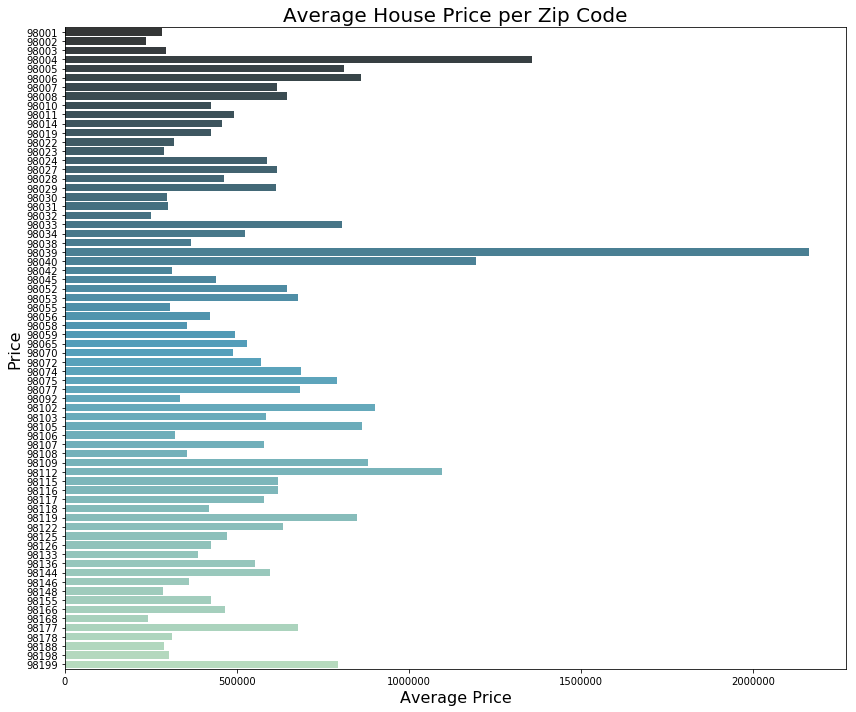

In [12]:
# Create horizontal bar chart to view average house price per zip code 
colors = sns.color_palette("GnBu_d", len(zips_df))
plt.figure(figsize=(12,10))
ax = sns.barplot(y = zips_df.zipcode , x = zips_df.price, data=zips_df, orient='h', palette=colors)
ax.set_xlabel(xlabel='Average Price', fontsize=16)
ax.set_ylabel(ylabel='Price', fontsize=16)
ax.set_title(label='Average House Price per Zip Code', fontsize=20)
plt.tight_layout()

In [13]:
# median latitude and longitude from the data set were used to generate a folium map
df.lat.median(), df.long.median(); #(47.5718, -122.23100000000001) 

# set initial map 
map_zips = folium.Map([47.5718, -122.23100000000001], zoom_start=11)

# create list of latitude and longitude coordinate pairs for folium markers
locations = zips_df[['lat', 'long']]
location_list = locations.values.tolist()

# create a string list of the zipcodes and average prices for each zipcode to input to folium markers
price = zips_df['zipcode'] + " $" + zips_df['price'].astype(int).astype(str)
price = price.values.tolist()

# For loop to create each marker from the lists
for i in range(0, len(location_list)):
    folium.Marker(location_list[i], popup=price[i]).add_to(map_zips)
map_zips

<img src="folium_map_marker.png">

From the above map and bar chart we can tell that Bellevue (zip code 98039) had the highest mean house price. The mean latitude, longitude for this zipcode will be used to calculate distance for each latitude longitude pair in the dataset. 

### Distance Feature

In [14]:
# A list of the latitude, longitude coordinates were made
coord = df[['lat', 'long']]
coordinates = coord.values.tolist()

# The distance between each point and the mean Bellevue coordinates was calculated and saved to a list
distances = []
for i in range(len(coordinates)):
    coords_1 = (47.625840, -122.233540) # Bellevue
    coords_2 = coordinates[i]
    distances.append(geopy.distance.vincenty(coords_1, coords_2).miles)

# The list of distances was transformed into a series and added to the main dataframe
df['distance'] = pd.DataFrame(distances)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,distance
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,7.995528
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,7.689150
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,7.741887
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,10.403648
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,8.828511


In [15]:
print(df.distance.describe())
print('-----------------------')
print(" ")
print('Correlation between price and distance feature: r = {}'.format(round(df.price.corr(df.distance),2)))

count    21597.000000
mean        10.860158
std          6.196645
min          0.147549
25%          6.518003
50%          9.014470
75%         13.836673
max         43.284758
Name: distance, dtype: float64
-----------------------
 
Correlation between price and distance feature: r = -0.4


Distance had a moderate inverse relationship with price (r = -.4) was therefore kept for further analysis. Zipcode was removed from the dataset as it was no longer needed. 

In [16]:
# drop zipcode
df.drop('zipcode', axis=1, inplace=True)

## Data Cleaning

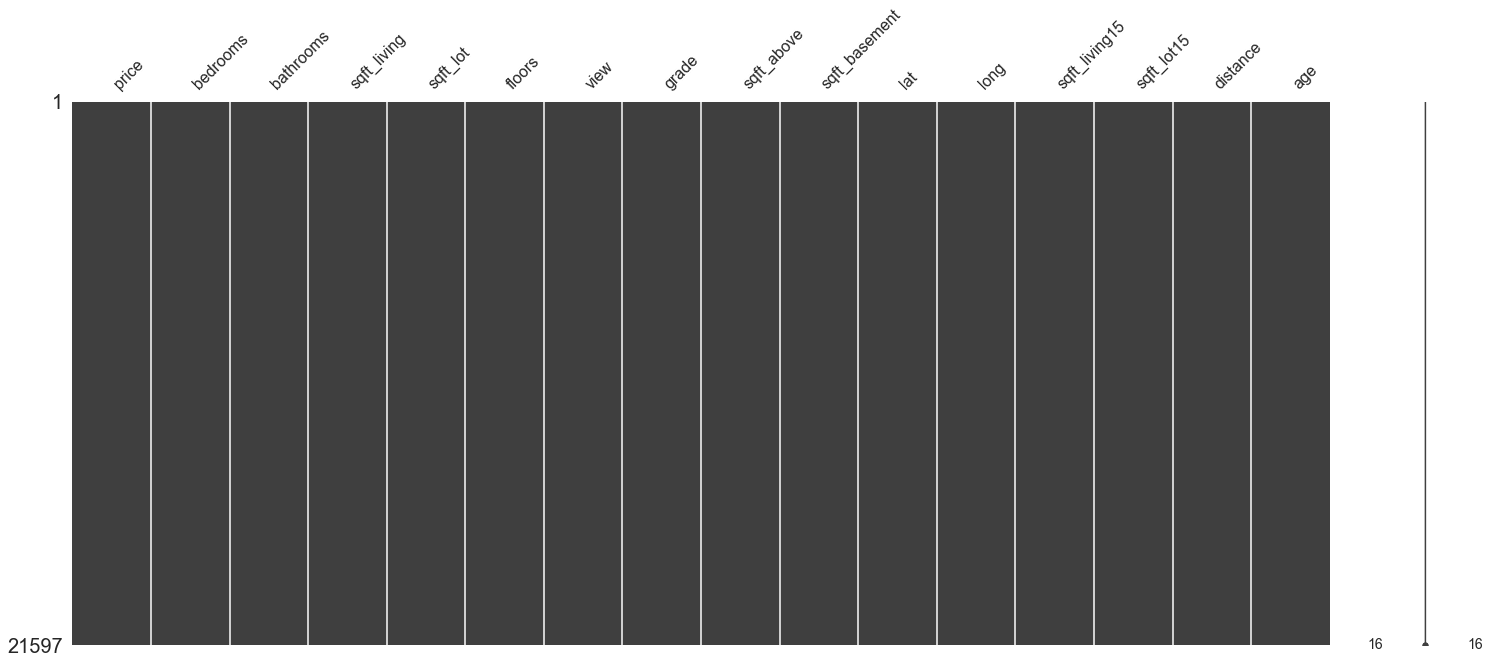

In [77]:
# Three features had missing values
msno.matrix(df);

In [18]:
# The data were further investigated for disproportionate values of 0.0

# zero values for numerical data were searched
value_finder(df, 0.0)

[{'Column': 'price', 0.0: 0},
 {'Column': 'bedrooms', 0.0: 0},
 {'Column': 'bathrooms', 0.0: 0},
 {'Column': 'sqft_living', 0.0: 0},
 {'Column': 'sqft_lot', 0.0: 0},
 {'Column': 'floors', 0.0: 0},
 {'Column': 'waterfront', 0.0: 19075},
 {'Column': 'view', 0.0: 19422},
 {'Column': 'condition', 0.0: 0},
 {'Column': 'grade', 0.0: 0},
 {'Column': 'sqft_above', 0.0: 0},
 {'Column': 'sqft_basement', 0.0: 0},
 {'Column': 'yr_built', 0.0: 0},
 {'Column': 'yr_renovated', 0.0: 17011},
 {'Column': 'lat', 0.0: 0},
 {'Column': 'long', 0.0: 0},
 {'Column': 'sqft_living15', 0.0: 0},
 {'Column': 'sqft_lot15', 0.0: 0},
 {'Column': 'distance', 0.0: 0}]

### Placeholders and Missing Values

A number of variables had missing values, disproportionate zero values, and placeholders. Each of the following variables will be dealt with in turn:
   - Sqft_basement
   - Year Renovated
   - View
   - Waterfront

##### SQFT_BASEMENT

In [19]:
# Sqrt_basement was inspected for astring placeholder as it is a numerical variable set as an object
(df['sqft_basement'] == '?').sum()

454

In [20]:
# sqft_basement has 454 unknown values 
# '?' placeholder was replaced with np.NaN

df['sqft_basement'].replace('?', np.NaN, inplace=True) 

# change the variable was then changed to float so that descriptive stats could be run
df['sqft_basement'] = df['sqft_basement'].astype(float)
df.sqft_basement.describe().round()

count    21143.0
mean       292.0
std        442.0
min          0.0
25%          0.0
50%          0.0
75%        560.0
max       4820.0
Name: sqft_basement, dtype: float64

In [ ]:
# 2% of the data in sqft_basement is null. This is a small enough percentage 
# where replacement via central measure should not impact the distribution or 
# analysis substantially

round(df.sqft_basement.isna().sum()/len(df.sqft_basement)*100, 2); 

In [22]:
# Inspection of sqft_basement stats indicate that the distribution is positively skewed. 
# Therefore, in this case the median rather than the mean can be used as a replacement value 
# (i.e., the central measure least likely to change the shape of the distribution)
df['sqft_basement'].replace(np.NaN, 0.0, inplace=True) 

# Number of zero values 
len(df.loc[df['sqft_basement'] == 0])

13280

In [23]:
# Despite many values of zero, sqft_basement was left in the analysis 
# due to a moderate correlation with price
print('Pearson correlation coefficent between sqft basement and price = {}'.format(round(df.sqft_basement.corr(df.price), 2)))

Pearson correlation coefficent between sqft basement and price = 0.32


In [24]:
# Feature converted to integer for clarity, as no floating points were apparent from descriptives
df.sqft_basement = df.sqft_basement.astype(int);

##### YEAR RENOVATED

In [80]:
# Years renovated was explored visually and checked for number of null values
print(df.yr_renovated.isna().sum())
df.hist('yr_renovated');
plt.title('Year Renovated')

AttributeError: 'DataFrame' object has no attribute 'yr_renovated'

In [81]:
# Further investigation of the non-zero values for this variable revealed that 
# only 3% of data were non zero, and furthermore, that this 3% held a very weak correlation 
# with the dependent variable (price). This variable was consequently deleted. 

df_temp = df.loc[df['yr_renovated'] > 0.0] # temporary dataframe with non-null values

KeyError: 'yr_renovated'

In [79]:
print('Percentage of non-value data points: {}%'.format(round(len(df_temp)/len(df)*100), 3))
print('Pearson correlation coefficent between price and year renovated: r = {}'.format(round(df_temp.price.corr(df.yr_renovated),2)))

# histogram of 3% non zero values 
df_temp['yr_renovated'].hist();
plt.title('Year Renovated 1930 - 2015')


Percentage of non-value data points: 3%


AttributeError: 'DataFrame' object has no attribute 'yr_renovated'

Due to the very small percentage of houses with the year of renovations recorded (3%) this variable will be dropped. It is clear that houses that were renovated have been given a value of 0, indicating that in addition to all of the missing data for this column a value of 0 also indicates missing data.

In [28]:
df.drop('yr_renovated', axis=1, inplace=True)

##### VIEW



In [29]:
print('Null values: {}'. format(df.view.isna().sum()))
print('Unique values: {}'. format(df.view.unique()))

Null values: 63
Unique values: [ 0. nan  3.  4.  2.  1.]


In [30]:
# The null values were replaced with the median
df.view.median()
df.view.replace(np.NaN, 0.0, inplace=True)
df.view.isna().sum()

0

In [31]:
# View was converted to type int
df.view = df.view.astype(int)
df.view.unique()

array([0, 3, 4, 2, 1], dtype=int64)

Pearson correlation coefficent between view and price: r = 0.2490823500473145
------------------------------------------------------------------


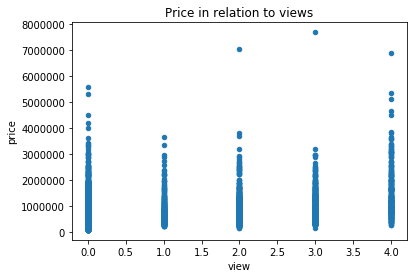

In [32]:
# Plot price and view, and get r corr
df.plot(x='view', y='price', kind='scatter')
plt.title('Price in relation to views');

print('Pearson correlation coefficent between view and price: r = {}'.format(df.view.corr(df.grade)))
print('------------------------------------------------------------------')

View is a measure of whether or not the property has been viewed. The value counts and scatter plot show that it is clearly interval data, with 0 being no views and the maximum number of views being 4. The vast majority of properties have not been viewed, which is resulting in an extreme positive skew.However, when viewed in relation to the target variable, there appears to be a mdoerate relationship with the price target. View will be kept and reconsidered after transformation to fix skew.  

##### WATERFRONT 

In [33]:
# Waterfront indicates whether a house has a view to the waterfront
df.waterfront.unique()
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [34]:
# Feature means in relation to whether a property has a waterfront view or not
waterfront_ave = round(df.groupby(['waterfront']).mean(), 2)
waterfront_ave.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,distance
waterfront,,,,,,,,,,,,,,,,,
0.0,532641.99,3.37,2.11,2073.52,14991.12,1.49,0.20,3.41,7.65,1785.88,281.45,1971.11,47.56,-122.21,1982.05,12729.49,10.87
1.0,1717214.73,3.35,2.71,3244.75,25870.88,1.63,3.76,3.54,8.84,2508.76,728.46,1962.28,47.54,-122.28,2682.83,22893.70,10.21


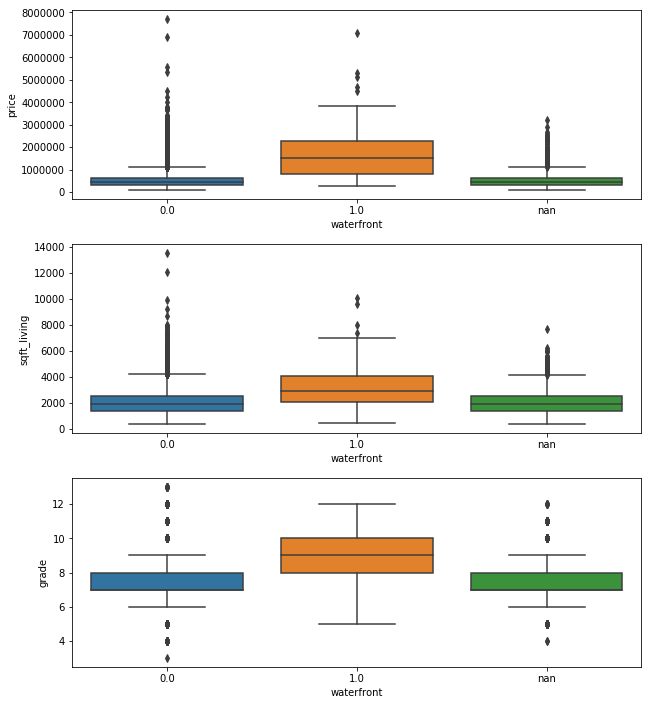

In [35]:
# replace waterfront missing values with NaN category to determine the descriptives for missing data
df.waterfront = df.waterfront.astype(str)

df.waterfront.replace(np.NaN, 'NaN', inplace=True)
df.waterfront.replace(0.0, 'False', inplace=True)
df.waterfront.replace(1.0, 'True', inplace=True)

# Plot the 3 waterfront subgroups in relation to price, sqft_living and grade
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(9,10))
sns.boxplot(x="waterfront", y="price", data=df, ax=ax1)
sns.boxplot(x="waterfront", y="sqft_living", data=df, ax=ax2)
sns.boxplot(x="waterfront", y="grade", data=df, ax=ax3)

f.tight_layout()

Waterfront contains only a very small percentage of houses; however, there appears to be a real difference in size and price, with a view of the waterfront leading to a median value that is within outlier range for price and beyond the 75th percentile for sqft_living. Nevertheless, values for the non-waterfront properties still fall within range of the other categories. While these data may be outliers, transformations may be able to deal with these data. Keeping them in the datset will mean better generalization of the model. 

In [36]:
percentage_waterfront_view = 146/len(df.waterfront)*100
print('Percentage of data points with a waterfront view: {}%'. format(round(percentage_waterfront_view,2)))

# remove the waterfront column
df.drop('waterfront', axis=1, inplace=True);

Percentage of data points with a waterfront view: 0.68%


Houses with a waterfront view made up 0.7% of the data, and therefore the waterfront column was removed as it is largely redundant. 

##### Final Inspection for unusual data

In [37]:
# visual inspection of data indicated no other placeholders (very unusual values). 
for col in df.columns:
    print(col)
    print(df[col].unique());

price
[221900. 538000. 180000. ... 541800. 610685. 402101.]
bedrooms
[ 3  2  4  5  1  6  7  8  9 11 10 33]
bathrooms
[1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75 6.25
 6.5 ]
sqft_living
[1180 2570  770 ... 3087 3118 1425]
sqft_lot
[ 5650  7242 10000 ...  5813  2388  1076]
floors
[1.  2.  1.5 3.  2.5 3.5]
view
[0 3 4 2 1]
condition
[3 5 4 1 2]
grade
[ 7  6  8 11  9  5 10 12  4  3 13]
sqft_above
[1180 2170  770 1050 1680 3890 1715 1060 1890 1860  860 1430 1370 1810
 1980 1600 1200 1250 2330 2270 1070 2450 1710 1750 1400  790 2570 2320
 1190 1510 1090 1280  930 2360  890 2620 2600 3595 1570  920 3160  990
 2290 2165 1640 1000 2130 2830 2250 2420 3250 1850 1590 1260 2519 1540
 1110 1770 2720 2240 3070 2380 2390  880 1040  910 3450 2350 1900 1010
  960 2660 1610  765 3520 1290 1960 1160 1210 1270 1440 2190 2920 1460
 1170 1240 3140 2030 2310  700 1080 2520 2780 1560 1450 1720 2910 1620
 1360 2070 246

In [38]:
# extreme values apparent in the descriptive statistics will be further evaluated below. 
df.describe().round()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,distance
count,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0
mean,540297.0,3.0,2.0,2080.0,15099.0,1.0,0.0,3.0,8.0,1789.0,286.0,1971.0,48.0,-122.0,1987.0,12758.0,11.0
std,367368.0,1.0,1.0,918.0,41413.0,1.0,1.0,1.0,1.0,828.0,440.0,29.0,0.0,0.0,685.0,27274.0,6.0
min,78000.0,1.0,0.0,370.0,520.0,1.0,0.0,1.0,3.0,370.0,0.0,1900.0,47.0,-123.0,399.0,651.0,0.0
25%,322000.0,3.0,2.0,1430.0,5040.0,1.0,0.0,3.0,7.0,1190.0,0.0,1951.0,47.0,-122.0,1490.0,5100.0,7.0
50%,450000.0,3.0,2.0,1910.0,7618.0,2.0,0.0,3.0,7.0,1560.0,0.0,1975.0,48.0,-122.0,1840.0,7620.0,9.0
75%,645000.0,4.0,2.0,2550.0,10685.0,2.0,0.0,4.0,8.0,2210.0,550.0,1997.0,48.0,-122.0,2360.0,10083.0,14.0
max,7700000.0,33.0,8.0,13540.0,1651359.0,4.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,48.0,-121.0,6210.0,871200.0,43.0


In [39]:
# The maximum for rooms is 33. This is likely a typo, as the property is very modest in terms of size. 
# All other data for this case appear reasonable, so bedrooms will be replaced with the mean/ 
# median value of 3 to retain the case. 

df.loc[df['bedrooms'] == 33, 'bedrooms'] = 3

df.bedrooms.max()

11

## Feature Engineering

### AGE
QUESTION: How best to deal with the measure of years?

In [40]:
# Year built was replaced with a variable called age that describes how old the property is. 
# The year 2015 was used as this was the year the data were collected. This new variable is 
# continuos and still contains the information related to years.  

df['age'] = 2015 - df['yr_built']

# Year built was dropped from the data set
df.drop('yr_built', axis=1, inplace=True)

### CATEGORICAL VARIABLES

- View 
- Condition

To avoid adding unnecessary dimensionality, a separate database with the following categorical variables was created. These will be run in an individual model to first test whether they add any value, and those that do will be add to the main model. 

In [41]:
cat_df = pd.DataFrame()

# Set data type for categorical variables  
cat_df['n_price'] = np.log(df['price'])
cat_df['view'] = df.view.astype('category')
cat_df['condition'] = df.condition.astype('category')

# Round floors to three categories
df.loc[df['floors'] == 1.5, 'floors'] = 1
df.loc[df['floors'] == 2.5, 'floors'] = 2
df.loc[df['floors'] == 3.5, 'floors'] = 3
df.floors = df.floors.astype(int);
cat_df['floors'] = df.floors.astype('category')

# Create dummy variables
cat_df = pd.get_dummies(cat_df);
cat_df.head()

,n_price,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,floors_1,floors_2,floors_3
0,12.309982,1,0,0,0,0,0,0,1,0,0,1,0,0
1,13.195614,1,0,0,0,0,0,0,1,0,0,0,1,0
2,12.100712,1,0,0,0,0,0,0,1,0,0,1,0,0
3,13.311329,1,0,0,0,0,0,0,0,0,1,1,0,0
4,13.142166,1,0,0,0,0,0,0,1,0,0,1,0,0


In [42]:
# Model each set of dummy variables separately to check how much variance each set is accouting for
cols_view = cat_df.columns[1:5]
cols_condition = cat_df.columns[6:10]
cols_floors = cat_df.columns[11:14]
 

cols = [cols_view, cols_condition , cols_floors]
for col in cols:
    sum_cols = "+".join(col)
    form = "n_price ~" + sum_cols
    model = smf.ols(formula= form, data= cat_df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                n_price   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     754.2
Date:                Sun, 04 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:47:05   Log-Likelihood:                -15380.
No. Observations:               21597   AIC:                         3.077e+04
Df Residuals:                   21592   BIC:                         3.081e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.0147      0.028    505.857      0.0

In [43]:
# Create transformed price target to test non-dummy transformed interval features
df['n_price'] = np.log(df['price'])

In [44]:
# Condition accounted for very little variance as a dummy coded variable, as well as without coding, 
# and will therefore be removed from the data set

formula0 = "n_price ~ condition" 
model0 = ols(formula= formula0, data=df).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     32.76
Date:                Sun, 04 Nov 2018   Prob (F-statistic):           1.06e-08
Time:                        20:47:05   Log-Likelihood:                -16776.
No. Observations:               21597   AIC:                         3.356e+04
Df Residuals:                   21595   BIC:                         3.357e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9408      0.019    677.338      0.000      12.903      12.978
condition      0.0315      0.006      5.723      0.000       0.021       0.042
==============================================================================
Omnibus:                      851.356   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1086.243
Skew:                           0.429   Prob(JB):                    1.33e-236
Kurtosis:                       3.686   Cond. No.                         20.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# Floors accounted for almost the same amount of variance as using dummy coding, 
# and therefore will be retained in interval form to avoid adding dimensionality

formula0 = "n_price ~ floors" 
model0 = ols(formula= formula0, data=df).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_price   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1925.
Date:                Sun, 04 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:47:05   Log-Likelihood:                -15870.
No. Observations:               21597   AIC:                         3.174e+04
Df Residuals:                   21595   BIC:                         3.176e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6533      0.010   1313.659      0.000      12.634      12.672
floors         0.2731      0.006     43.878      0.000       0.261       0.285
==============================================================================
Omnibus:                      843.316   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1029.107
Skew:                           0.444   Prob(JB):                    3.41e-224
Kurtosis:                       3.597   Cond. No.                         5.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# Grade accounted for almost identical variance without dummy coding and will 
# be retained as an interval data type to avoid added dimensionality 

formula0 = "n_price ~ view" 
model0 = ols(formula= formula0, data=df).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_price   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     2911.
Date:                Sun, 04 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:47:05   Log-Likelihood:                -15426.
No. Observations:               21597   AIC:                         3.086e+04
Df Residuals:                   21595   BIC:                         3.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9929      0.004   3694.865      0.000      12.986      13.000
view           0.2373      0.004     53.953      0.000       0.229       0.246
==============================================================================
Omnibus:                      371.300   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.570
Skew:                           0.268   Prob(JB):                     1.58e-95
Kurtosis:                       3.444   Cond. No.                         1.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# drop from main dataset
df.drop(['n_price','condition'], axis=1, inplace=True)


### Extreme Values

In [48]:
# Z-scores were created to investigate extreme values in the price target 
df_z = (df - df.mean())/df.std()

print('The number of cases beyond 3.29 standard deviations: {}'.format(len(df_z.loc[df_z['price'] > 3.29])))

tail = len(df_z.loc[df_z['price'] > 3.29])  
print('The percentage of cases beyond 3.29 standard deviations: {}%'.format((tail/len(df_z))*100))
print('--------------------------------------------------------------')

The number of cases beyond 3.29 standard deviations: 326
The percentage of cases beyond 3.29 standard deviations: 1.5094689077186645%
--------------------------------------------------------------


1.5% (326 cases) fall outside of + 3.29 Standard deviations of price.This should be 0.13% for normally distributed data. However, log transformations are often able to deal with right skew well. If we are able to retain all of the information in the dataset and use a transformation to make the analysis more robust, this may result in a more generalizable (not overfitted) model. Since our goal at this point is predictive accuracy for the whole of King County, retaining all of the data is desirable for now. 

## Transformations

In [49]:
df2 = df # create copy for transformation and scaling
df2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,distance,age
0,221900.0,3,1.00,1180,5650,1,0,7,1180,0,47.5112,-122.257,1340,5650,7.995528,60
1,538000.0,3,2.25,2570,7242,2,0,7,2170,400,47.7210,-122.319,1690,7639,7.689150,64
2,180000.0,2,1.00,770,10000,1,0,6,770,0,47.7379,-122.233,2720,8062,7.741887,82
3,604000.0,4,3.00,1960,5000,1,0,7,1050,910,47.5208,-122.393,1360,5000,10.403648,50
4,510000.0,3,2.00,1680,8080,1,0,8,1680,0,47.6168,-122.045,1800,7503,8.828511,28


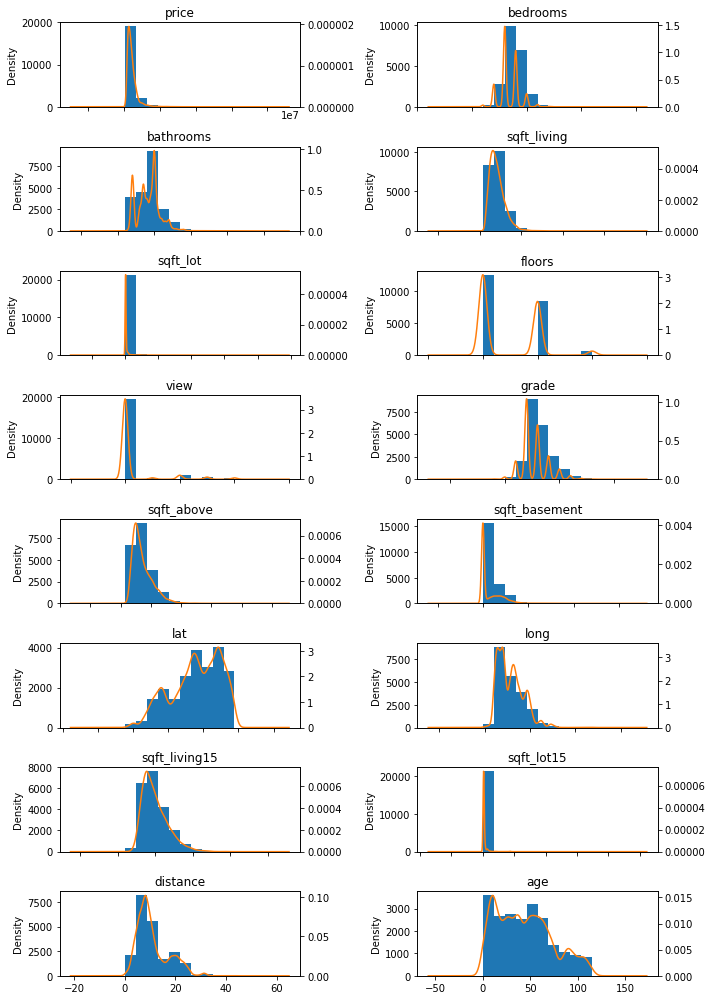

In [50]:
# Keep track of total number of subplots
k = len(df2.columns)

# n will be the number of chart columns. Change this to suit individual needs.  
# m will be the calculated number of required rows based on k and n
n = 2
m = (k - 1) // n + 1

# Create a figure and array of axes with required number of rows and columns.
fig, axes = plt.subplots(m, n, figsize=(10,14))

# Iterate through columns, tracking the column name and which number we are at i. 
# Within each iteration, plot.
for i, (name, col) in enumerate(df2.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)


fig.tight_layout()

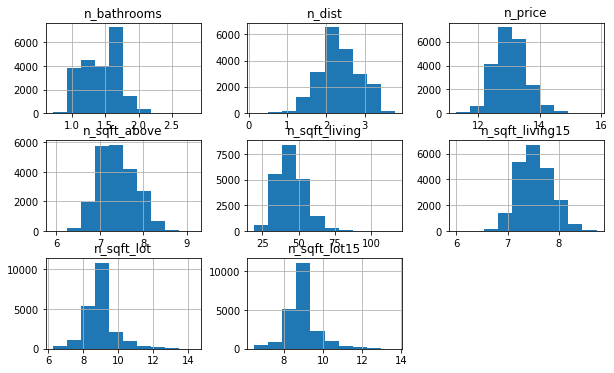

In [51]:
data_norm = pd.DataFrame([])
data_norm["n_price"] = np.log(df2["price"])
data_norm['n_sqft_living'] = np.sqrt(df2['sqft_living'])
data_norm['n_dist'] = np.log(df2['distance'] +1)
data_norm['n_sqft_lot15'] = np.log(df2['sqft_lot15'] +1)
data_norm['n_sqft_lot'] = np.log(df2['sqft_lot'] + 1)
data_norm['n_bathrooms'] = np.sqrt(df2['bathrooms'])
data_norm['n_sqft_above'] = np.log(df2['sqft_above'])
data_norm['n_sqft_living15'] = np.log(df2['sqft_living15'])
data_norm.hist(figsize  = [10,6]);

fig.tight_layout()

In [52]:
df3 = data_norm.merge(df, left_index=True, right_index=True)

In [53]:
# Remove untransformed features from data set
to_drop = ['price', 'sqft_living', 'distance','bathrooms','sqft_lot', 'sqft_above','sqft_living15', 'sqft_lot15'] 
           #'age',, 'renovated_lot']
df3.drop(to_drop, axis=1, inplace=True)

In [54]:
#standardize data set
df_zz=(df3-df3.mean())/df3.std()

#create copy of the standardized dataset including original price variable for later interpretation
price = df2.loc[:,['price']]

df_z2 = df_zz.merge(price, left_index=True, right_index=True)
df_z2.head()

#create copy of the standardized dataset to use for modeling
df_z = df_z2.drop('price', axis=1)

## Correlations and Multicolinearity

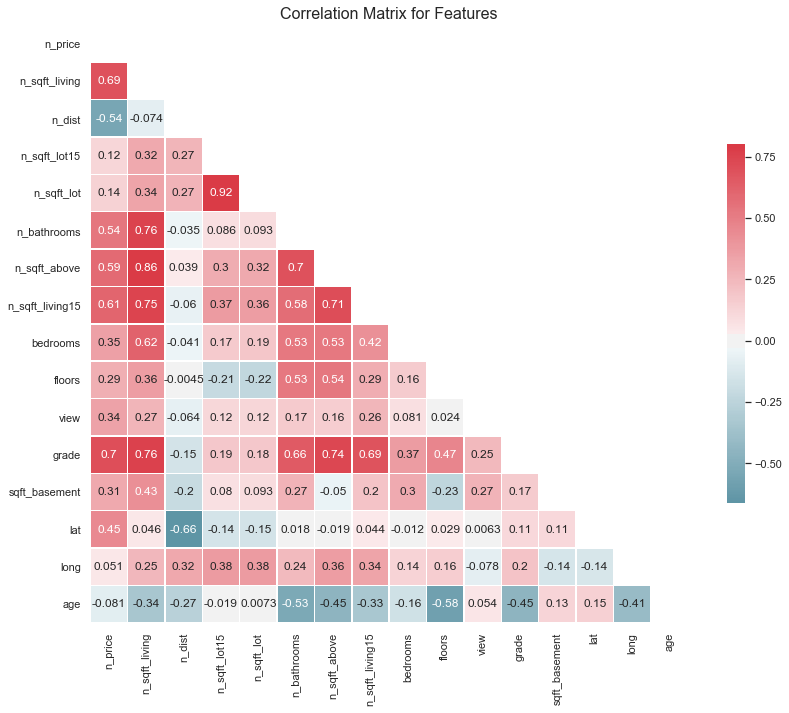

In [55]:
# Correlation matrix for all features retained thus far
corr_matrix(df_z)
plt.title('Correlation Matrix for Features', fontsize=16);

Despite high intercorrelations amid features, all predictors were retained to try and determine predictive accuracy (multicollinearity will be addressed later when understanding which features are having an impact is investigated).

## Predictive Accuracy

In [56]:
# Forward Selection was used to select features and determine the 
# order of effect size (i.e., largest to smallest beta)
model = forward_selected(df_z, 'n_price')

print(model.model.formula)
# sl ~ rk + yr + 1

print(model.rsquared_adj)

n_price ~ grade + n_dist + n_sqft_living + view + lat + age + n_sqft_living15 + long + n_bathrooms + bedrooms + n_sqft_above + n_sqft_lot + floors + n_sqft_lot15 + sqft_basement + 1
0.8154544575636746


Determining features via forward selection, the model had a predictive accuracy of 81.5%. Validation of this method and the number of features for a good fit were further explored. 

In [57]:
# Using the transformed and standardized dataset
x = df_z.drop('n_price', axis=1)
y = df_z.n_price

# Run a series of linear regressions increasing the number of features each time
linreg = LinearRegression()

# Number of features to loop through
list_n = list(range(1,17))
for n in list_n: 
    # add a feature each loop
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(x, np.ravel(y))
    selected_columns = x.columns[select_n.support_ ]
    
    # run a regression for n features 
    linreg.fit(x[selected_columns],y)
    
    # calculate R-squared
    yhat = linreg.predict(x[selected_columns])
    SS_Residual = np.sum((y-yhat)**2)
    SS_Total = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    print('Features: ' + str(n))
    print('R-squared:           ' + str(r_squared))
    
    # Calculate adjusted R-squared
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1)
    print('Adjusted R- sqaured: ' + str(adjusted_r_squared))
    print('--------------------------------------------------')

Features: 1
R-squared:           0.4804769388918707
Adjusted R- sqaured: 0.48011584135623186
--------------------------------------------------
Features: 2
R-squared:           0.7249727546389968
Adjusted R- sqaured: 0.7247815953470078
--------------------------------------------------
Features: 3
R-squared:           0.7650434394260281
Adjusted R- sqaured: 0.764880131497359
--------------------------------------------------
Features: 4
R-squared:           0.7780585264523756
Adjusted R- sqaured: 0.7779042647359021
--------------------------------------------------
Features: 5
R-squared:           0.7966364890462557
Adjusted R- sqaured: 0.7964951400511069
--------------------------------------------------
Features: 6
R-squared:           0.8007952130806771
Adjusted R- sqaured: 0.8006567546309394
--------------------------------------------------
Features: 7
R-squared:           0.8066203202825706
Adjusted R- sqaured: 0.8064859106075898
--------------------------------------------------

In [58]:
# The model was run using a train-test split of 20-80 to test generalizability of the results 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

# A feature was added for every iteration of the train-test for the total number of features
list_n = list(range(1,17))
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(x_train, np.ravel(y_train))
    selected_columns = x.columns[select_n.support_ ]
    linreg.fit(x_train[selected_columns],y_train)
    yhat_train = linreg.predict(x_train[selected_columns])
    yhat_test = linreg.predict(x_test[selected_columns])
    mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
    mse_test =np.sum((y_test-yhat_test)**2)/len(y_test)
    print('Features: ' + str(n))
    print('mse train: ' + str(mse_train))
    print('mse test:  '+ str(mse_test))
    print('train_mse/test_mse: {}'.format(mse_train/mse_test))
    print('---------------------')

Features: 1
mse train: 0.5157599588803408
mse test:  0.5346419587682958
train_mse/test_mse: 0.9646829067971858
---------------------
Features: 2
mse train: 0.2735100384308321
mse test:  0.2811328422895481
train_mse/test_mse: 0.9728854025142142
---------------------
Features: 3
mse train: 0.233848711605769
mse test:  0.239413394394401
train_mse/test_mse: 0.9767570114332661
---------------------
Features: 4
mse train: 0.22107065973985518
mse test:  0.2254512884358086
train_mse/test_mse: 0.9805695113727385
---------------------
Features: 5
mse train: 0.2025308823736483
mse test:  0.2067029324413473
train_mse/test_mse: 0.9798162028064946
---------------------
Features: 6
mse train: 0.19834669262608384
mse test:  0.20264411977789923
train_mse/test_mse: 0.9787932304350828
---------------------
Features: 7
mse train: 0.1926746807700394
mse test:  0.19621051846432022
train_mse/test_mse: 0.9819793672533219
---------------------
Features: 8
mse train: 0.19080155552447134
mse test:  0.19385539954

In [59]:
# Use k folds to run train-test cross validation for comparision to the method above, using 5 features 
select_5 = RFE(linreg, n_features_to_select = 5)
select_5 = select_n.fit(x, np.ravel(y))
selected_columns = x.columns[select_n.support_]

cv_10_results = cross_val_score(linreg, x[selected_columns], y, cv=10)

cv_10_results

array([0.80724619, 0.81626697, 0.80642465, 0.81966523, 0.8002118 ,
       0.81502438, 0.81746073, 0.82625761, 0.81313529, 0.80792436])

The above validation methods all showed that the model reached maximum accuracy and minimum error after approximately 7 features. After this point it could be argued that the model is being overfitted and that adding more features is no longer adding to the predictive ability of the model. Therefore, which features are adding substantially to the model will be further investigated to gain better understanding. 

### Best Features

High intercorrelations were especially seen between those variables related to size, as there is a large overlap with regards to what is being measured. Features related to living size were modeled individually (using the forward selection and correlation sizes with the price target as a guide) to establish which to retain for the final model. 

In [60]:
formula = "n_price ~ n_sqft_living" 
model = ols(formula= formula, data=df_z).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                 1.997e+04
Date:                Sun, 04 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:47:43   Log-Likelihood:                -23573.
No. Observations:               21597   AIC:                         4.715e+04
Df Residuals:                   21595   BIC:                         4.717e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8.129e-14      0.005   1.66e-11      1.000      -0.010       0.010
n_sqft_living     0.6932      0.005    141.322      0.000       0.684       0.703
==============================================================================
Omnibus:                      108.581   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.485
Skew:                           0.086   Prob(JB):                     6.10e-20
Kurtosis:                       2.738   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
formula2 = "n_price ~ n_sqft_living + n_sqft_living15+ n_bathrooms+bedrooms+n_sqft_above" 
model2 = ols(formula= formula2, data=df_z).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     4497.
Date:                Sun, 04 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:47:43   Log-Likelihood:                -22938.
No. Observations:               21597   AIC:                         4.589e+04
Df Residuals:                   21591   BIC:                         4.594e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.155e-14      0.005   2.42e-12      1.000      -0.009       0.009
n_sqft_living       0.6776      0.012     56.991      0.000       0.654       0.701
n_sqft_living15     0.2024      0.007     27.449      0.000       0.188       0.217
n_bathrooms         0.0523      0.007      7.048      0.000       0.038       0.067
bedrooms           -0.1219      0.006    -19.814      0.000      -0.134      -0.110
n_sqft_above       -0.1158      0.010    -11.902      0.000      -0.135      -0.097
==============================================================================
Omnibus:                      108.602   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.640
Skew:                           0.082   Prob(JB):                     9.32e-20
Kurtosis:                       2.735   Cond. No.                         5.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Sqft_living had the highest correlation with price, and has an R-square of 0.48. 
Adding sqft_living15, bedrooms, bathrooms and sqft_above result in an R-square of 0.51. 

Only sqft_living will be retained for the final model, as it is clear that all other features related to size of the house/ building are adding only negligably to the model; for the sake of interpretability, only the primary contributing feature is warranted. 

Those features shown to have low correlations with the price target and that were placed seventh to last in the list generated by the forwards selection were removed. ```n_price ~ grade + n_dist + n_sqft_living + view + lat + age + n_sqft_living15 + long + n_bathrooms + bedrooms + n_sqft_above + n_sqft_lot + floors + n_sqft_lot15 + sqft_basement + 1``` 

In [62]:
final = df_z.drop(['n_sqft_living15','long', 'n_sqft_lot', 'n_bathrooms', 'bedrooms', 'n_sqft_above', 'floors', 'age', 'n_sqft_lot15'], axis=1)

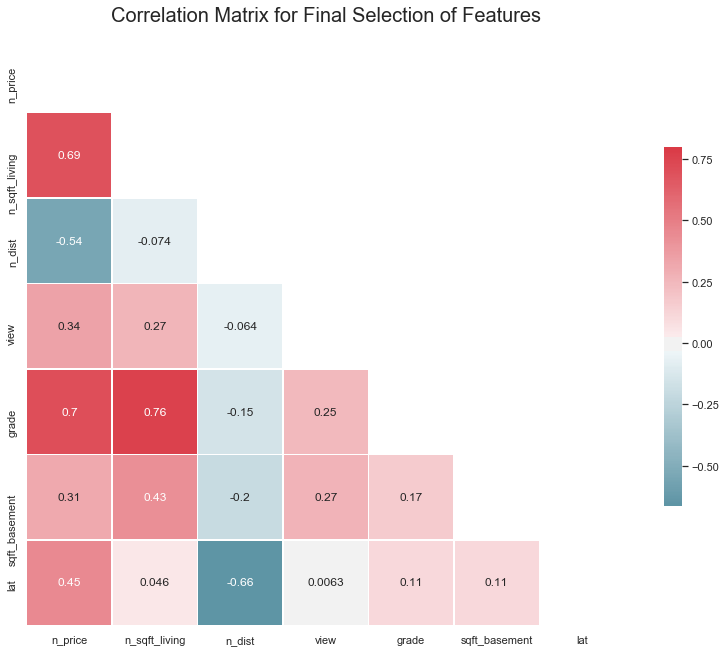

In [63]:
corr_matrix(final)
plt.title('Correlation Matrix for Final Selection of Features', fontsize=20);

In [64]:
# Forward Selection was used to select features and determine the order of effect size 
# (i.e., largest to smallest beta)
model = forward_selected(final, 'n_price')

print(model.model.formula)
# sl ~ rk + yr + 1

print(model.rsquared_adj)

n_price ~ grade + n_dist + n_sqft_living + view + lat + sqft_basement + 1
0.7983089906382781


### FINAL MODEL

The final model included grade, distance, square foot living, views and latitude. Each feature was added to the model one at a time to get some indication of the R-square change for each feature. 

- Model 1:   price ~ grade                                                  = 49.5% 
- Model 2.1: price ~ grade + distance                                       = 69.1% (R-square change: 0.196)
- Model 2.2: price ~ sqft_living + distance + sqft_living                   = 76.5% (R-square change: 0.074)
- Model 3:   price ~ sqft_living + distance + sqft_living + view            = 78.2% (R-square change: 0.070)
- Model 4:   price ~ sqft_living + distance + sqft_living + view + lat      = 79.7% (R-square change: 0.015)

These R-squared changes cannot be interpreted directly, as this is not unique variance that each feature is accounting for. For instance, when sqft_living is added to the model first, it also accounts for 48% of the variance, but when added third is only accounting for an additional 7.4% after grade and distance. Part and partial correlations should be examined to interpret individual contributions. 

As the dataset was transformed and standardized, the beta coefficients cannot be interpreted in the original measurement units. If we interpret magnitude and direction of the coefficients, all except distance have a positive relationship to price. 

The follwing formula can be used to give an indication of the magnitude of the relationship to price:

$ Price = 0.29* grade + -0.35* distance + 0.40* sqft living + 0.14* views + 0.16* latitude $

In [65]:
# Statistics for final model
formula = "n_price ~ grade + n_dist + n_sqft_living + view + lat" 
model = ols(formula= formula, data=final).fit()
warnings.filterwarnings('ignore')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_price   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.692e+04
Date:                Sun, 04 Nov 2018   Prob (F-statistic):               0.00
Time:                        20:47:43   Log-Likelihood:                -13445.
No. Observations:               21597   AIC:                         2.690e+04
Df Residuals:                   21591   BIC:                         2.695e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.227e-15      0.003  -1.05e-12      1.000      -0.006       0.006
grade             0.2918      0.005     60.769      0.000       0.282       0.301
n_dist           -0.3542      0.004    -85.779      0.000      -0.362      -0.346
n_sqft_living     0.3994      0.005     83.522      0.000       0.390       0.409
view              0.1421      0.003     44.412      0.000       0.136       0.148
lat               0.1617      0.004     39.399      0.000       0.154       0.170
==============================================================================
Omnibus:                      484.383   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1105.156
Skew:                          -0.030   Prob(JB):                    1.04e-240
Kurtosis:                       4.107   Cond. No.                         2.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Diagnostics

In [66]:
# Calculate VIP (Variance Inflation Factor) to interpret multicollinearity in the model 

y1 = final['n_price']
x1 = final.drop(['n_price', 'sqft_basement'], axis=1)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x1.values, i) for i in range(x1.shape[1])]
vif["features"] = x1.columns
vif.round(1)


,VIF Factor,features
0,2.4,n_sqft_living
1,1.8,n_dist
2,1.1,view
3,2.4,grade
4,1.8,lat


Variance Inflation Factor indicates whether a predictor has a strong linear relationship with other predictors. There are no hard rules for VIF cutoff, but larger scores are cause for concern. Some authors indicate that values greater than 10 are of concern, while others argue that an average over 1 indicates some bias due to multicollinearity. Although no scores were above 10, the average is 1.8, slightly over one. The reciprocal of VIF --> 1/VIF is also used to interpret multicollinearity. A value below 0.2 is usally cause for concern. Our lowest value is 0.4, indicating that while there may be some bias in the model due to intercorrelations, the issue is not severe enough to hinder interpretability.

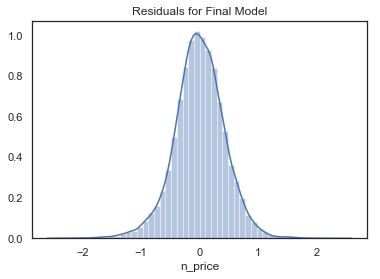

In [82]:
# Plotting residuals showed good normality
warnings.filterwarnings('ignore')
residuals = y - yhat

#residuals.hist()
sns.distplot(residuals)
plt.title('Residuals for Final Model');

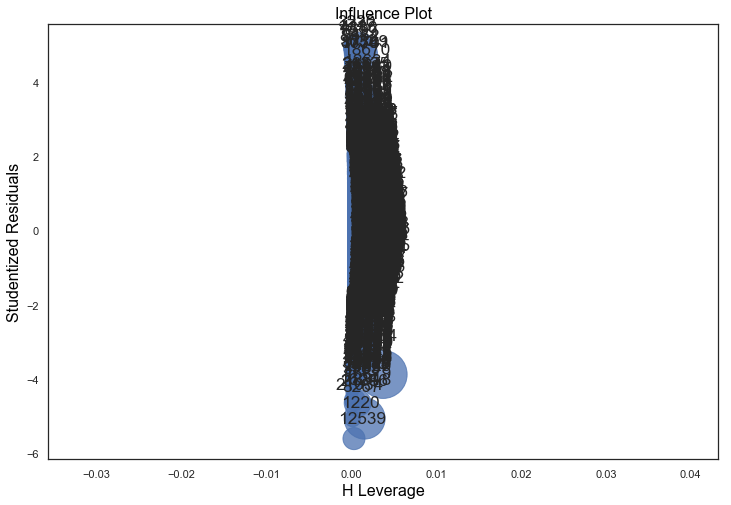

In [68]:
# Investigate any outliers having undue influemce on the model
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

In [69]:
# Get model statistics
m = model
infl = m.get_influence()
model_stats = infl.summary_frame()
model_stats.head()

,dfb_Intercept,dfb_grade,dfb_n_dist,dfb_n_sqft_living,dfb_view,dfb_lat,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.012192,-0.004594,0.008748,0.011916,0.001198,0.009011,0.000073,-1.791482,0.000137,-0.020969,-1.791574,-0.020970
1,-0.001196,0.002023,-0.000499,-0.002079,0.000391,-0.001531,0.000001,-0.175810,0.000283,-0.002957,-0.175806,-0.002957
2,-0.014552,0.003411,-0.008316,0.014799,-0.003420,-0.020739,0.000227,-2.138040,0.000298,-0.036905,-2.138217,-0.036908
3,0.012507,-0.009769,-0.001317,0.007777,-0.003185,-0.002635,0.000047,1.837897,0.000083,0.016721,1.837998,0.016722
4,0.002760,0.002449,0.000704,-0.002417,-0.000714,0.001122,0.000003,0.405638,0.000101,0.004084,0.405630,0.004084


Despite a few cases with some influence, there were none seen to be problematic (i.e., have extensive distance from the rest as well as inflation). Furthermore, none had a cooks distance greater than 1. All cases will be retained for now. 

### Exploring Features Further

Due to the difficulty in trying to interpret the price values for the betas, the original price  and feature columns were inserted into the transformed and standardized dataset. The figures below use the original metric for either the target or features to illustrate the relationships between the 5 main features and the target.  

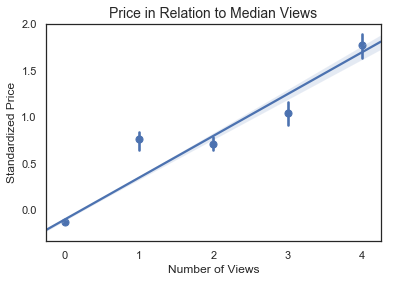

In [70]:
# Import original scaled features
df_z2['grade_orig'] = df2.loc[:,['grade']]
df_z2['view_orig'] = df2.loc[:,['view']]
df_z2['distance_orig'] = df2.loc[:,['distance']]
df_z2['sqft_orig'] = df2.loc[:,['sqft_living']]

# Plot relationship between price and median views
sns.set(color_codes=True)
sns.set_style("white")

sns.regplot(x='view_orig', y='n_price', data=df_z2, x_estimator=np.median)
plt.title('Price in Relation to Median Views', fontsize=14)
plt.xlabel('Number of Views')
plt.ylabel('Standardized Price')
f.tight_layout()

In [71]:
df_z2.head()

,n_price,n_sqft_living,n_dist,n_sqft_lot15,n_sqft_lot,n_bathrooms,n_sqft_above,n_sqft_living15,bedrooms,floors,...,grade,sqft_basement,lat,long,age,price,grade_orig,view_orig,distance_orig,sqft_orig
0,-1.401998,-1.075331,-0.280869,-0.395502,-0.388490,-1.601667,-0.753565,-1.035429,-0.411251,-0.808449,...,-0.560787,-0.649622,-0.352886,-0.305688,0.544665,221900.0,7,0,7.995528,1180
1,0.279938,0.639003,-0.347670,-0.024341,-0.113302,0.262292,0.672693,-0.326781,-0.411251,1.004267,...,-0.560787,0.259841,1.161349,-0.746268,0.680835,538000.0,7,0,7.689150,2570
2,-1.799430,-1.767845,-0.336006,0.041983,0.244426,-1.601667,-1.752954,1.126504,-1.517328,-0.808449,...,-1.413157,-0.649622,1.283325,-0.135141,1.293596,180000.0,6,0,7.741887,770
3,0.499698,-0.034738,0.176404,-0.545897,-0.523969,1.127359,-1.026835,-0.990187,0.694825,-0.808449,...,-0.560787,1.419407,-0.283598,-1.272122,0.204243,604000.0,7,0,10.403648,1960
4,0.178434,-0.379207,-0.110148,-0.046448,0.008081,-0.057513,0.073515,-0.134218,-0.411251,-0.808449,...,0.291583,-0.649622,0.409284,1.200812,-0.544688,510000.0,8,0,8.828511,1680


In [72]:
# Use the transformed and scaled price column to get values in the original price metric 
m_values = df_z2.groupby(['n_price']).mean()
m_values = m_values.reset_index()
m_values.head();

In [141]:
# Get mean price values for each interval in the scaled target 
prices = {}
prices['3 to 4'] = m_values.loc[(m_values['n_price'] > 3.0) & (m_values['n_price'] < 4.0)]['price'].mean()
prices['2 to 3'] = m_values.loc[(m_values['n_price'] > 2.0) & (m_values['n_price'] < 3.0)]['price'].mean()
prices['1 to 2'] = m_values.loc[(m_values['n_price'] > 1.0) & (m_values['n_price'] < 2.0)]['price'].mean()
prices['0 to 1'] = m_values.loc[(m_values['n_price'] > 0.0) & (m_values['n_price'] < 1.0)]['price'].mean()
prices['-1 to 0'] = m_values.loc[(m_values['n_price'] > -1.0) & (m_values['n_price'] < 0.0)]['price'].mean()
prices['-2 to -1'] = m_values.loc[(m_values['n_price'] > -2.0) & (m_values['n_price'] < -1.0)]['price'].mean()
prices['-3 to -2'] = m_values.loc[(m_values['n_price'] > -3.0) & (m_values['n_price'] < -2.0)]['price'].mean()
prices['-4 to -3'] = m_values.loc[(m_values['n_price'] > -4.0) & (m_values['n_price'] < -3.0)]['price'].mean()
prices_df = pd.DataFrame.from_dict(prices, orient='index')
prices_df.round()
prices_df.reset_index(inplace=True)
prices_df.round()
#labels = list(prices.keys())
#labels

,index,0
0,3 to 4,2786190.0
1,2 to 3,1769647.0
2,1 to 2,903289.0
3,0 to 1,609270.0
4,-1 to 0,365629.0
5,-2 to -1,224921.0
6,-3 to -2,137194.0
7,-4 to -3,85568.0


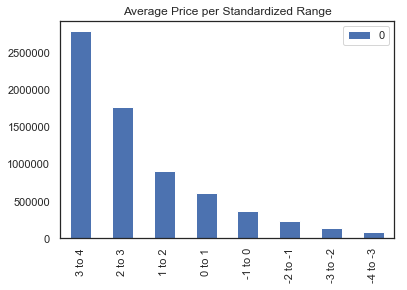

In [136]:
prices_df.rename(columns = {'0': 'price_mean'}, inplace=True)
prices_df.plot(kind='bar')
# set the locations and labels of the xticks
plt.xticks( np.arange(8), 
           ('3 to 4','2 to 3','1 to 2','0 to 1','-1 to 0','-2 to -1','-3 to -2','-4 to -3') );
plt.title('Average Price per Standardized Range');

In [74]:
# The price value in the original metric for to transformed price = 0
m_values.loc[(m_values['n_price'] > -0.001) & (m_values['n_price'] < 0.001)]['price'].mean()

464275.0

The color split in the below charts is where transformed price is equal to zero. A value of zero correspons to $464275, and is the median split in the data. Therefore, blue is below median prices and pink above. 

Text(43,0.5,'Price')

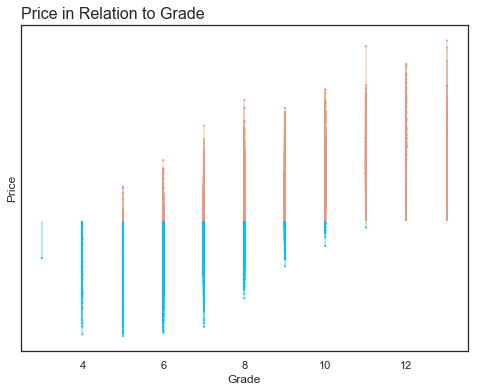

In [158]:
# Plot relationship between transformed target and grade in the original scale
x = df_z2.grade_orig
y = df_z2.n_price

# Create a color if the group is "B"
my_color=np.where(y>=0, 'darksalmon', 'deepskyblue')

fig, ax = plt.subplots(figsize=(8,6))

# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()

# The vertival plot is made using the hline function
plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=0.4)
plt.scatter(x, y, color=my_color, s=1, alpha=1)

# Hide yaxis ticks
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_ticks([])


# Add title and axis names
plt.title("Price in Relation to Grade", loc='left', fontsize=16)
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
 
#plt.yticks(np.arange(85000,2500000, step=250000));
           
           #np.arange(1), 
           #('$460000') );


Text(43,0.5,'Price')

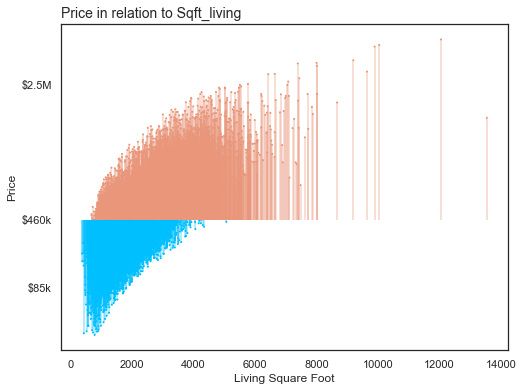

In [156]:
# Plot relationship between transformed target and sqft_living in the original scale
x = df_z2.sqft_orig
y = df_z2.n_price

# Create a color if the group is "B"
my_color=np.where(y>=0, 'darksalmon', 'deepskyblue')

fig, ax = plt.subplots(figsize=(8,6))

# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()

# The vertival plot is made using the hline function
plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=0.4)
plt.scatter(x, y, color=my_color, s=1, alpha=1)
#cur_axes = plt.gca()
#cur_axes.axes.get_yaxis().set_ticks([])


labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = "$85k"
labels[2] = '$460k'
labels[3] = ""
labels[4] = '$2.5M'

ax.set_yticklabels(labels)
 
# Add title and axis names
plt.title("Price in relation to Sqft_living", loc='left', fontsize=14)
plt.xlabel('Living Square Foot', fontsize = 12)
plt.ylabel('Price', fontsize=12)

#### Future Analysis

- time series analysis
- spatial analysis (i.e., using latitude and longitude to incorporate more demographic data)
- focusing on splitting the market into: luxury, general, and agricultural